## Challenge: Boston Marathon  
## Kevin Hahn  

So in essence, I took two approaches. One where I specified a pseudo outcome variable to be predicted (i.e., whether that racer was in the top 20% of overall times or not) and another approach where I entered all of the columns as if they had no relationship to one another.

Dimensionality reduction with Principal Component Analysis revealed strong factor loading values, unsurprisingly, for time at 40 kilometers into the race (i.e., very close to the end) as well as for age and gender. After reducing the feature set to 2 components with PCA, the meanshift method suggested a 6 cluster solution which was explored in the other approach. 

By reducing the number of clusters in the k-means method to 2 and reducing the dimensionality of the dataset to 2 components with PCA, the method did correctly identify all of the rows belonging to the bottom 80% of the race data; however, only about 20% of those belonging to the top 20% of the race overall were correctly identified and clustered together). See Figure 1:

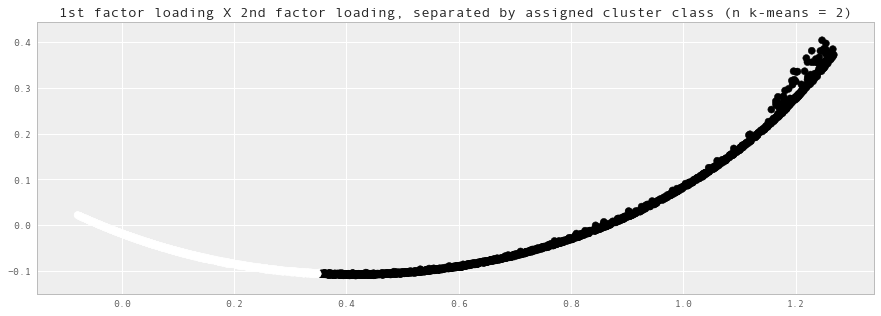

Comparing k-means clusters against the data:
col_0        0     1
Actuals             
0        25266     0
1         5116  1267


In [606]:
### Figure 1
MySpecialPCA = PCA(n_components=2)
X_pca = MySpecialPCA.fit_transform(X_norm)

#Run k-means with n clusters
km = KMeans(n_clusters=2, random_state=42)

y_pred = km.fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.title("1st factor loading X 2nd factor loading, separated by assigned cluster class (n k-means = 2)")
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y, y_pred, rownames=["Actuals"]))

Meanshift and spectral clustering revealed similar findings but were too memory intensive to replicate with higher number of clusters or PCA dimensions.

From there I decided to take a more "blind" approach to the data and see what clustering solution the computer identifies on its own. First, I removed all of the columns containing unique or string data (i.e., name, bib number, city, state, country of citizenship (many NaNs), official time (directly related to overall ranking), pace, and division class). I also removed many of the race time markers because they were so directly related, leaving only the time at 5 kilometers, time at the halfway point, and overall ordinal ranking. 

Norming the data without PCA dimension reduction and then applying the k-means method with 6 clusters revealed clustering primarily distinguished by gender (see Figure 2): 

In [ ]:
## Figure 2
sns.lmplot(x='overall', y='gender', hue='cluster', palette='pastel', data=labeled_runners, ci=None, x_ci=None, 
           fit_reg=False,
           size=8, aspect=2, markers='o')
plt.ylim([-1, 2])
plt.yticks([0, 1], ("Female", "Male"))

Figure 3 plots overall ranking on the x-axis against ranking within gender division on the y-axis: 

In [ ]:
## Figure 3
sns.lmplot(x='overall', y='genderdiv', hue='cluster', palette='husl', data=labeled_runners, ci=None, x_ci=None, 
           size=8, aspect=1.5, markers='o', fit_reg=None)

Interestingly, using these two variables, the clusters seem to cover differences in the shape of the slope of each segment of the male and female classes. You can see curvature in clusters 1 (males) and 4 (females), and other clusters appear as the slopes straighten out (cluster 2 for males and cluster 0 for females). Clusters 3 and 5 are more hidden on this graph but generally contain the fastest competitors. Yet curiously, cluster 5 is made up of males only.

Cluster 3 was the only class to contain some males and females; all other clusters had only males OR females. Cluster 3 also had some of the best overall rankings, including the first-place runner:

In [592]:
#Table 1: Descriptive stats on Cluster 3
labeled_runners[labeled_runners['cluster'] == 3].describe().round(2)

,5k,half,overall,gender,age,genderdiv,CtyCode,cluster
count,149.00,149.00,149.00,149.00,149.00,149.00,149.00,149.0
mean,14.13,62.60,42.09,0.81,31.50,28.47,62.13,3.0
std,3.31,12.03,29.27,0.40,7.47,21.87,20.15,0.0
min,7.75,38.03,1.00,0.00,18.00,1.00,7.00,3.0
25%,10.12,49.93,19.00,1.00,27.00,10.00,55.00,3.0
50%,15.63,68.80,38.00,1.00,30.00,23.00,74.00,3.0
75%,16.77,71.68,59.00,1.00,34.00,42.00,74.00,3.0
max,18.18,83.05,140.00,1.00,59.00,81.00,74.00,3.0


So although the clustering methods did not do a great job at identifying those in the top 20% overall when I labeled the data as such, the methods did perform fairly well at clustering runners based on their gender and overall performance. 

I want to close with this final visualization (see Figure 4) that shows that age generally did not generally impact one's cluster assignment. Although clustering did distinguish between individuals based on their overall rank and their identified gender; generally, all ages were represented in all clusters with the possible exception of the smallest two clusters (cluster 3 (fastest individuals) and cluster 5 (relatively fast males)).

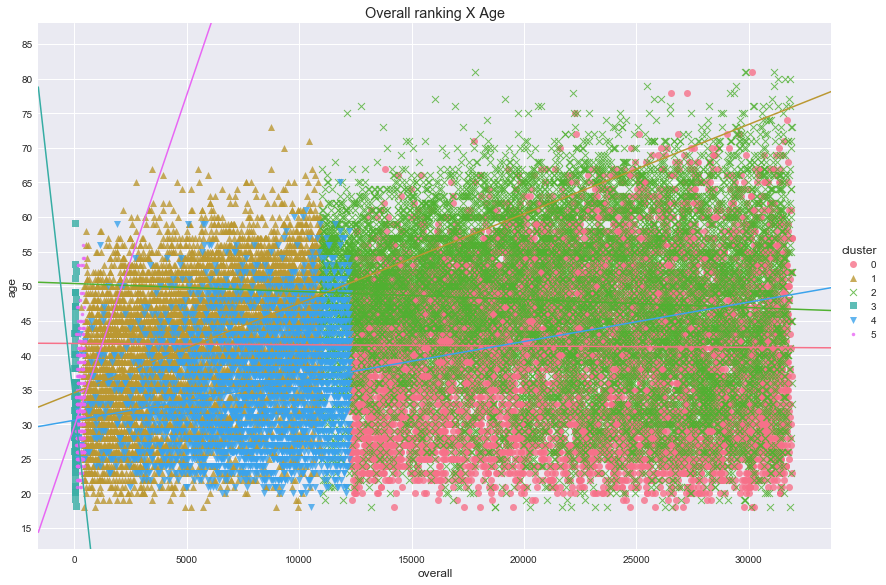

In [593]:
### Figure 4
sns.lmplot(x='overall', y='age', hue='cluster', palette='husl', data=labeled_runners, ci=None, x_ci=None, 
           size=8, aspect=1.5, markers=['o','^','x',',','v','.'])
plt.ylim([12,88])
plt.yticks([15,20,25,30,35,40,45,50,55,60,65,70,75,80,85])
plt.title("Overall ranking X Age")

## Run from here and below to load up the data

In [594]:
# import cPickle
import _pickle as cPickle
import pickle
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import matplotlib
import mpld3, mpld3.plugins
import numpy as np
from collections import Counter
from itertools import cycle
import pandas as pd
import seaborn as sns

import scipy
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

%matplotlib inline

pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [595]:
# runners3 = cPickle.load("~/Documents/DataScienceBootcamp/bostonmarathon/results/2014/results.pkl")

#local environment
# runners = pd.read_csv("~/Documents/DataScienceBootcamp/bostonmarathon/results/2014/results.csv")

#interwebs
runners = pd.read_csv("https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv")

In [596]:
# Assigning column names

runners = runners[[
 '5k',
 '10k',
 '20k',
 'half',
 '25k',
 '30k',
 '35k',
 '40k',
 'official', #time overall
 'name',
 'division',   #mystery variable
 'gender',   #confirmed that contains only M and F entries
 'age',
 'bib',  #ID number
 'genderdiv',  #ranking within gender class
 'ctz', # lots of NaNs - it's citizenship vs country of residence ('country') but many are missing
 'overall', #ranking overall
 'pace', #not really sure, could be approximate pace of each mile? roughly becomes 26.2 when 'official' divided by 'pace'
 'state',  #could group for US participants
 'country',  # could group by country
 'city']]

In [597]:
# Changing datatypes
runners = runners.replace(to_replace='-', value=np.nan)
runners['5k'] = runners['5k'].astype(float)
runners['10k'] = runners['10k'].astype(float)
runners['20k'] = runners['20k'].astype(float)
runners['half'] = runners['half'].astype(float)
runners['25k'] = runners['25k'].astype(float)
runners['30k'] = runners['30k'].astype(float)
runners['35k'] = runners['35k'].astype(float)
runners['40k'] = runners['40k'].astype(float)
runners['official'] = runners['official'].astype(float)
runners['age'] = runners['age'].astype(int)
runners['gender'] = runners['gender'].apply(lambda x: 1 if x == 'M' else 0) # males 1, females 0
runners['country'] = runners['country'].astype('category')
runners['CtyCode'] = runners['country'].cat.codes

In [598]:
runners.shape

(31984, 22)

In [599]:
runners.dtypes

5k            float64
10k           float64
20k           float64
half          float64
25k           float64
30k           float64
35k           float64
40k           float64
official      float64
name           object
division        int64
gender          int64
age             int64
bib            object
genderdiv       int64
ctz            object
overall         int64
pace          float64
state          object
country      category
city           object
CtyCode          int8
dtype: object

## With a featured outcome variable

In [600]:
#ditches NAs and variables with string data, as well as the overall column which TopGroup is based on
runners = runners.drop(['name', 'state', 'ctz', 'division', 'bib', 'city', 
                        'country', 
                        'official', # this is their official time which is directly related to overall ranking
                        'pace'], axis=1) # add country back in

top_runners = runners.overall.quantile(0.2)
top_runners

# 1 if in Top 20% of rankings overall, not separated by gender, 0 if in bottom 80%
runners['TopGroup'] = runners.overall.apply(lambda x: 1 if x <= top_runners else 0)

runners = runners.dropna()

runners = runners.drop(['overall'], axis=1)
runners.shape

(31649, 13)

In [601]:
list(runners)

['5k',
 '10k',
 '20k',
 'half',
 '25k',
 '30k',
 '35k',
 '40k',
 'gender',
 'age',
 'genderdiv',
 'CtyCode',
 'TopGroup']

In [602]:
# #Split into X and y groups
y = runners['TopGroup']
X = runners.drop('TopGroup', axis=1)

In [603]:
### Normalize the data
X_norm = normalize(X)

In [604]:
### Reduce dimensions
MySpecialPCA = PCA(n_components=2)

# Reduce it to n components.
X_pca = MySpecialPCA.fit_transform(X_norm)

In [605]:
#Run k-means with n clusters
km = KMeans(n_clusters=2, random_state=42)

y_pred = km.fit_predict(X_pca)

runners = runners.copy() 
runners['cluster'] = km.labels_

runners.head()

,5k,10k,20k,half,25k,30k,35k,40k,gender,age,genderdiv,CtyCode,TopGroup,cluster
0,8.02,17.37,37.65,39.72,47.67,59.18,71.40,80.43,1,47,8,41,1,1
1,16.22,32.58,65.83,69.47,82.43,99.33,116.37,132.10,0,33,1,42,1,1
2,7.75,16.62,36.10,38.03,45.80,56.45,67.42,76.10,1,41,1,59,1,1
3,16.20,32.57,65.83,69.47,82.43,99.33,116.37,132.95,0,24,3,26,1,1
4,8.02,17.12,36.58,38.60,46.37,57.03,67.83,76.72,1,40,2,41,1,1


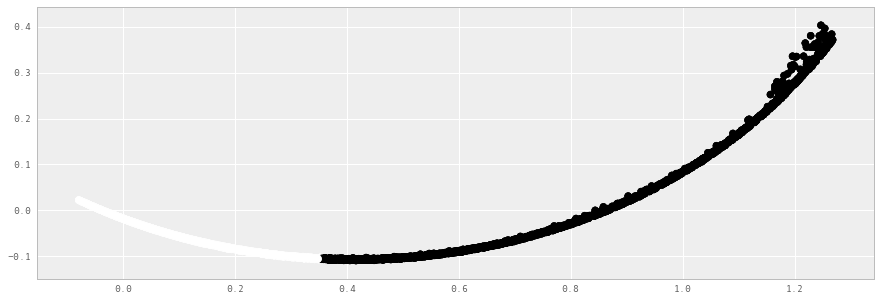

Comparing k-means clusters against the data:
col_0        0     1
Actuals             
0        25266     0
1         5116  1267


In [463]:
### K-Means

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y, y_pred, rownames=["Actuals"]))

In [414]:
MySpecialPCA.components_

i = np.identity(X.shape[1])

coef = MySpecialPCA.transform(i)

factor_loadings = pd.DataFrame(coef, columns=['PC-1', 'PC-2', 'PC-3', 'PC-4', 'PC-5'], index=X.columns)

factor_loadings.sort_values(by='PC-1', ascending=False)

,PC-1,PC-2,PC-3,PC-4,PC-5
40k,0.872564,0.605835,0.162554,-0.086361,0.556799
35k,0.813805,0.646474,0.151205,-0.051569,0.274885
30k,0.753650,0.679883,0.141323,-0.067747,-0.102450
25k,0.694858,0.712537,0.129192,-0.084645,-0.346136
half,0.650451,0.738876,0.117243,-0.086082,-0.414280
20k,0.638198,0.746679,0.113775,-0.083692,-0.404997
CtyCode,0.616417,0.835526,-0.920679,-0.044507,-0.014294
10k,0.525154,0.814406,0.085838,-0.089117,-0.341405
age,0.513007,0.873392,0.073702,0.952969,-0.056006
5k,0.469474,0.850389,0.072222,-0.076092,-0.204980


In [395]:
# #Split into X and y groups
y = runners['TopGroup']
X = runners.drop('TopGroup', axis=1)

### Normalize the data
X_norm = normalize(X)

### Reduce dimensions
MySpecialPCA = PCA(n_components=2)

# Reduce it to n components.
X_pca = MySpecialPCA.fit_transform(X_norm)

Number of estimated clusters: 6


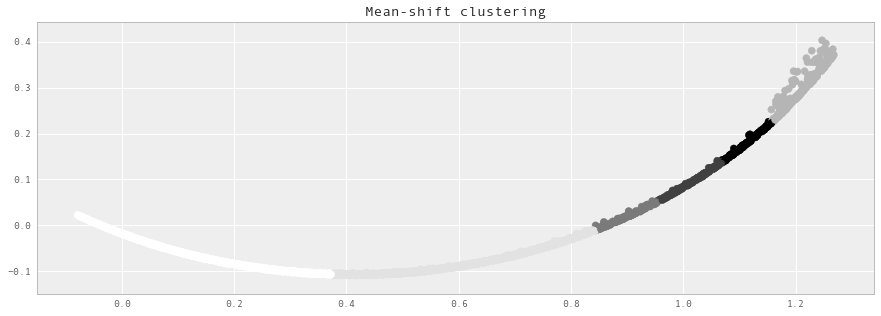

Comparing the assigned categories to the ones in the data:
col_0         0    1    2    3    4   5
TopGroup                               
0         25266    0    0    0    0   0
1          5176  756  163  108  101  79

2.7321885769997607


In [399]:
### Meanshift Method

# First reducing to two dimensions
y = runners['TopGroup']
X = runners.drop('TopGroup', axis=1)

X_norm = normalize(X)
MySpecialPCA = PCA(n_components=2)
X_pca = MySpecialPCA.fit_transform(X_norm)

km_start = timer()

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_pca, quantile=0.2, n_samples=200)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_pca)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))
# print(pd.crosstab(y_train, ms))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.title("Mean-shift clustering")
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y,labels))

km_end = timer()
print('')
print(km_end - km_start)

In [ ]:
### Spectral Clustering

sc_start = timer()

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters_)

#Predicted clusters.
predict=sc.fit_predict(X_pca)

#Graph results.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predict)
plt.title("Spectral clustering")
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y, predict))

sc_end = timer()
print(sc_end - sc_start) 

## With "all" variables 

In [537]:
## Reloading dataset

#interwebs
runners = pd.read_csv("https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv")

# Assigning column names

runners = runners[[
 '5k',
 '10k',
 '20k',
 'half',
 '25k',
 '30k',
 '35k',
 '40k',
 'official', #time overall
 'name',
 'division',   #mystery variable
 'gender',   #confirmed that contains only M and F entries
 'age',
 'bib',  #ID number
 'genderdiv',  #ranking within gender class
 'ctz', # lots of NaNs - it's citizenship vs country of residence ('country') but many are missing
 'overall', #ranking overall
 'pace', #not really sure, could be approximate pace of each mile? roughly becomes 26.2 when 'official' divided by 'pace'
 'state',  #could group for US participants
 'country',  # could group by country
 'city']]

# Changing datatypes
runners = runners.replace(to_replace='-', value=np.nan)
runners['5k'] = runners['5k'].astype(float)
runners['10k'] = runners['10k'].astype(float)
runners['20k'] = runners['20k'].astype(float)
runners['half'] = runners['half'].astype(float)
runners['25k'] = runners['25k'].astype(float)
runners['30k'] = runners['30k'].astype(float)
runners['35k'] = runners['35k'].astype(float)
runners['40k'] = runners['40k'].astype(float)
runners['official'] = runners['official'].astype(float)
runners['age'] = runners['age'].astype(int)
runners['gender'] = runners['gender'].apply(lambda x: 1 if x == 'M' else 0) # males 1, females 0
runners['country'] = runners['country'].astype('category')
runners['CtyCode'] = runners['country'].cat.codes

# Removing outliers
runners = runners[runners['5k'] <= 50] #Removes just two outliers with very extreme 5k values

In [538]:
runners.shape

(31927, 22)

In [539]:
#ditches NAs and variables with string data
runners = runners.drop(['name', 'state', 'ctz', 'division', 'bib', 'city', 
                        'country', 
                        'official', # this is their official time which is directly related to overall ranking
                        'pace'], axis=1)

runners = runners.dropna()

runners.shape

(31647, 13)

In [540]:
print(list(runners))

['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k', 'gender', 'age', 'genderdiv', 'overall', 'CtyCode']


In [541]:
#based on experience, also removes several race time marker increments
runners = runners.drop(['10k', '20k', '25k', '30k', '35k', '40k'], axis = 1)

In [542]:
runners = runners[['5k', 'half', 'overall', 'gender', 'age', 'genderdiv', 'CtyCode']]

In [543]:
X = runners

In [544]:
### Normalize the data
X_norm = normalize(X)

In [545]:
### Reduce dimensions
MySpecialPCA = PCA(n_components=None)

# Reduce it to n components.
X_pca = MySpecialPCA.fit_transform(X_norm)

In [546]:
#Run k-means with n clusters
km = KMeans(n_clusters=6, random_state=42)

y_pred = km.fit_predict(X_pca)

In [547]:
labeled_runners = runners.copy() 
labeled_runners['cluster'] = km.labels_

In [548]:
heatmap = labeled_runners.corr()

In [549]:
#Size of each cluster
labeled_runners['cluster'].value_counts()

0    10573
2     9395
1     7646
4     3563
5      321
3      149
Name: cluster, dtype: int64

In [550]:
### filter by cluster, plot/EDA on that cluster(s)

#Cluster 0
labeled_runners[labeled_runners['cluster'] == 0].describe().round(2)

,5k,half,overall,gender,age,genderdiv,CtyCode,cluster
count,10573.00,10573.00,10573.00,10573.0,10573.00,10573.00,10573.00,10573.0
mean,28.23,123.69,21795.27,0.0,41.30,8918.07,68.18,0.0
std,3.38,17.13,5633.42,0.0,10.76,3073.63,17.47,0.0
min,20.32,88.03,12246.00,0.0,18.00,3596.00,0.00,0.0
25%,25.68,110.53,16897.00,0.0,32.00,6257.00,74.00,0.0
50%,27.47,118.82,21600.00,0.0,42.00,8917.00,74.00,0.0
75%,30.43,133.48,26639.00,0.0,49.00,11576.00,74.00,0.0
max,48.83,198.45,31926.00,0.0,81.00,14355.00,75.00,0.0


In [551]:
#Cluster 1
labeled_runners[labeled_runners['cluster'] == 1].describe().round(2)

,5k,half,overall,gender,age,genderdiv,CtyCode,cluster
count,7646.00,7646.00,7646.00,7646.0,7646.00,7646.00,7646.00,7646.0
mean,21.52,91.20,5027.60,1.0,41.08,4229.21,63.95,1.0
std,1.55,6.28,2976.26,0.0,9.35,2214.35,21.51,0.0
min,15.65,68.73,294.00,1.0,18.00,267.00,0.00,1.0
25%,20.53,86.97,2445.25,1.0,34.00,2311.25,74.00,1.0
50%,21.45,90.82,4686.50,1.0,42.00,4226.50,74.00,1.0
75%,22.53,95.85,7420.75,1.0,48.00,6144.75,74.00,1.0
max,29.48,111.65,10996.00,1.0,73.00,8072.00,75.00,1.0


In [552]:
#Cluster 2
labeled_runners[labeled_runners['cluster'] == 2].describe().round(2)

,5k,half,overall,gender,age,genderdiv,CtyCode,cluster
count,9395.00,9395.00,9395.00,9395.0,9395.00,9395.00,9395.00,9395.0
mean,27.52,120.00,21572.14,1.0,47.87,12783.22,66.13,2.0
std,3.56,17.30,6014.81,0.0,11.98,2725.33,19.02,0.0
min,17.90,79.43,10977.00,1.0,18.00,8063.00,0.00,2.0
25%,24.73,106.67,16358.00,1.0,39.00,10423.50,74.00,2.0
50%,27.18,116.97,21805.00,1.0,49.00,12781.00,74.00,2.0
75%,29.87,130.25,26813.50,1.0,57.00,15143.50,74.00,2.0
max,48.15,236.67,31931.00,1.0,81.00,17575.00,77.00,2.0


In [553]:
#Cluster 3
labeled_runners[labeled_runners['cluster'] == 3].describe().round(2)

,5k,half,overall,gender,age,genderdiv,CtyCode,cluster
count,149.00,149.00,149.00,149.00,149.00,149.00,149.00,149.0
mean,14.13,62.60,42.09,0.81,31.50,28.47,62.13,3.0
std,3.31,12.03,29.27,0.40,7.47,21.87,20.15,0.0
min,7.75,38.03,1.00,0.00,18.00,1.00,7.00,3.0
25%,10.12,49.93,19.00,1.00,27.00,10.00,55.00,3.0
50%,15.63,68.80,38.00,1.00,30.00,23.00,74.00,3.0
75%,16.77,71.68,59.00,1.00,34.00,42.00,74.00,3.0
max,18.18,83.05,140.00,1.00,59.00,81.00,74.00,3.0


In [554]:
#Cluster 4
labeled_runners[labeled_runners['cluster'] == 4].describe().round(2)

,5k,half,overall,gender,age,genderdiv,CtyCode,cluster
count,3563.00,3563.00,3563.00,3563.0,3563.00,3563.00,3563.00,3563.0
mean,23.31,99.06,8258.63,0.0,35.30,1808.59,67.83,4.0
std,1.36,5.41,2778.47,0.0,8.14,1033.41,18.08,0.0
min,16.92,72.60,105.00,0.0,18.00,14.00,0.00,4.0
25%,22.48,95.85,6428.50,0.0,28.00,914.50,74.00,4.0
50%,23.47,99.98,8684.00,0.0,35.00,1808.00,74.00,4.0
75%,24.23,102.90,10559.50,0.0,41.00,2703.50,74.00,4.0
max,27.68,111.78,12247.00,0.0,65.00,3597.00,76.00,4.0


In [555]:
#Cluster 5
labeled_runners[labeled_runners['cluster'] == 5].describe().round(2)

,5k,half,overall,gender,age,genderdiv,CtyCode,cluster
count,321.00,321.00,321.00,321.0,321.00,321.00,321.00,321.0
mean,18.07,76.59,266.53,1.0,32.30,242.40,69.35,5.0
std,0.77,2.60,100.86,0.0,6.93,97.17,15.46,0.0
min,15.20,67.37,81.00,1.0,21.00,69.00,0.00,5.0
25%,17.58,74.88,181.00,1.0,27.00,159.00,74.00,5.0
50%,18.12,76.97,265.00,1.0,31.00,239.00,74.00,5.0
75%,18.57,78.33,352.00,1.0,37.00,325.00,74.00,5.0
max,20.33,82.90,458.00,1.0,56.00,427.00,74.00,5.0


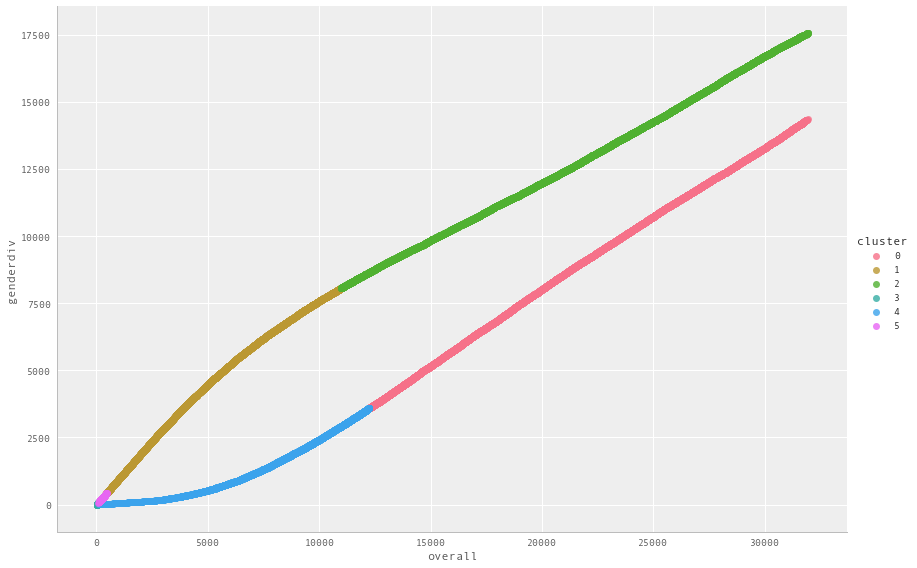

In [556]:
sns.lmplot(x='overall', y='genderdiv', hue='cluster', palette='husl', data=labeled_runners, ci=None, x_ci=None, 
           size=8, aspect=1.5, markers='o', fit_reg=None)


([<matplotlib.axis.YTick at 0x37cb697b8>,
 <a list of 2 Text yticklabel objects>)

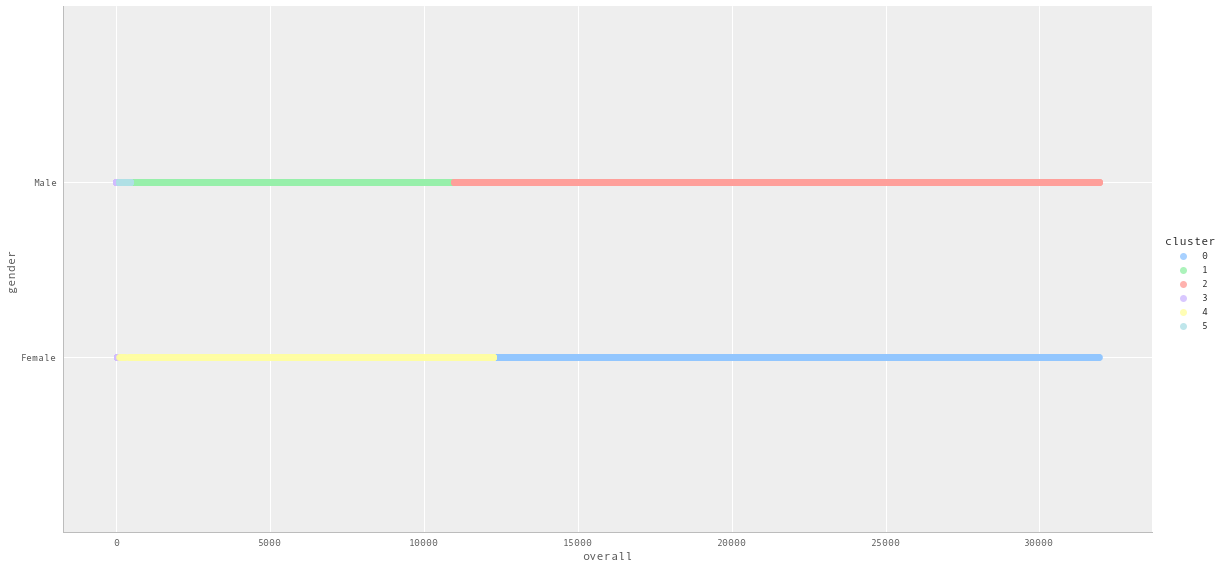

In [572]:
sns.lmplot(x='overall', y='gender', hue='cluster', palette='pastel', data=labeled_runners, ci=None, x_ci=None, 
           fit_reg=False,
           size=8, aspect=2, markers='o')
plt.ylim([-1, 2])
plt.yticks([0, 1], ("Female", "Male"))

([<matplotlib.axis.YTick at 0x3819fc7f0>,
 <a list of 15 Text yticklabel objects>)

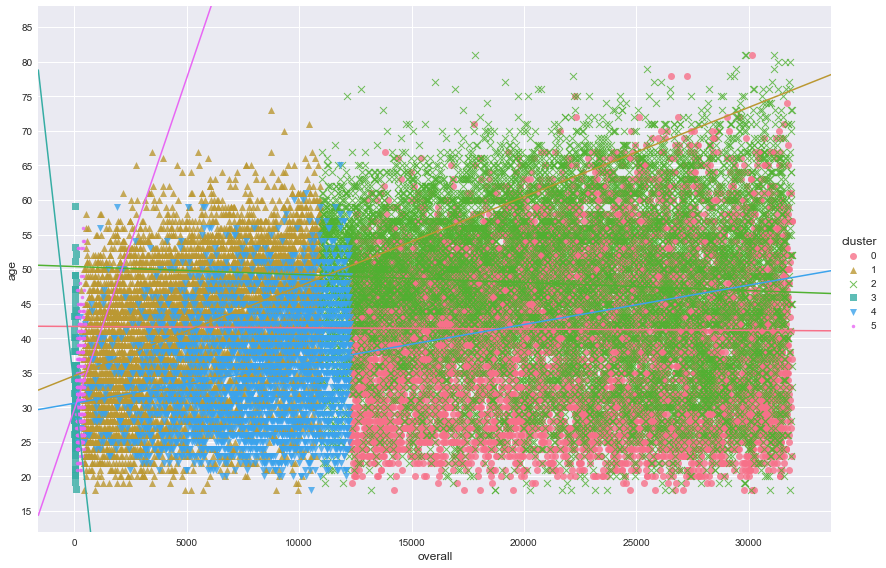

In [582]:
sns.lmplot(x='overall', y='age', hue='cluster', palette='husl', data=labeled_runners, ci=None, x_ci=None, 
           size=8, aspect=1.5, markers=['o','^','x',',','v','.'])
plt.ylim([12,88])
plt.yticks([15,20,25,30,35,40,45,50,55,60,65,70,75,80,85])

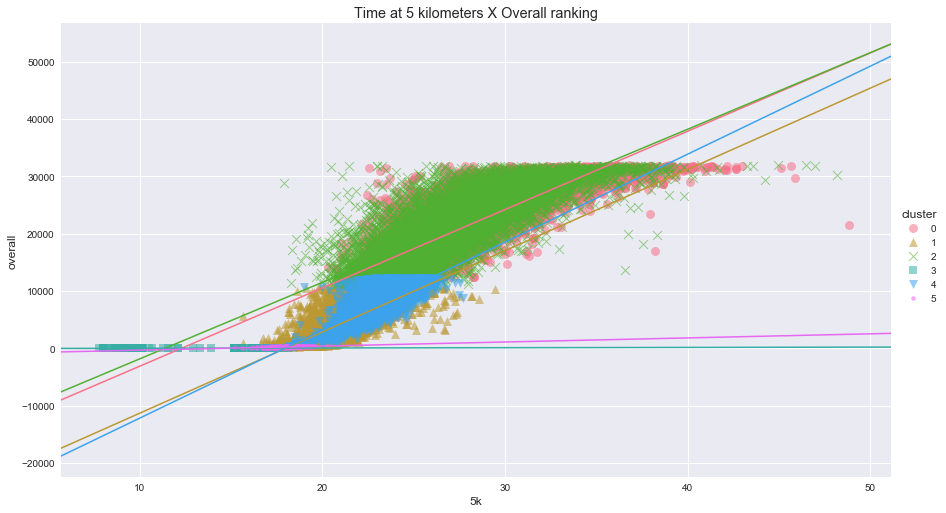

In [585]:
sns.lmplot(x='5k', y='overall', hue='cluster', palette='husl',
           data=labeled_runners, ci=None, x_ci=None, size=7, aspect=1.8, markers=['o','^','x',',','v','.'],
           scatter_kws={"s": 80,'alpha':0.55}
           )
plt.title("Time at 5 kilometers X Overall ranking")

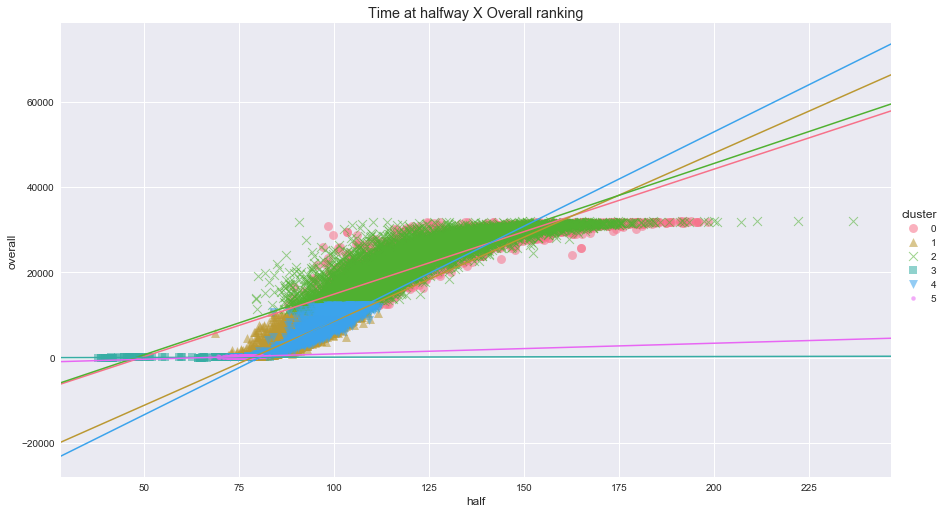

In [586]:
sns.lmplot(x='half', y='overall', hue='cluster', palette='husl',
           data=labeled_runners, ci=None, x_ci=None, size=7, aspect=1.8, markers=['o','^','x',',','v','.'],
           scatter_kws={"s": 80,'alpha':0.55}
           )

plt.title("Time at halfway X Overall ranking")

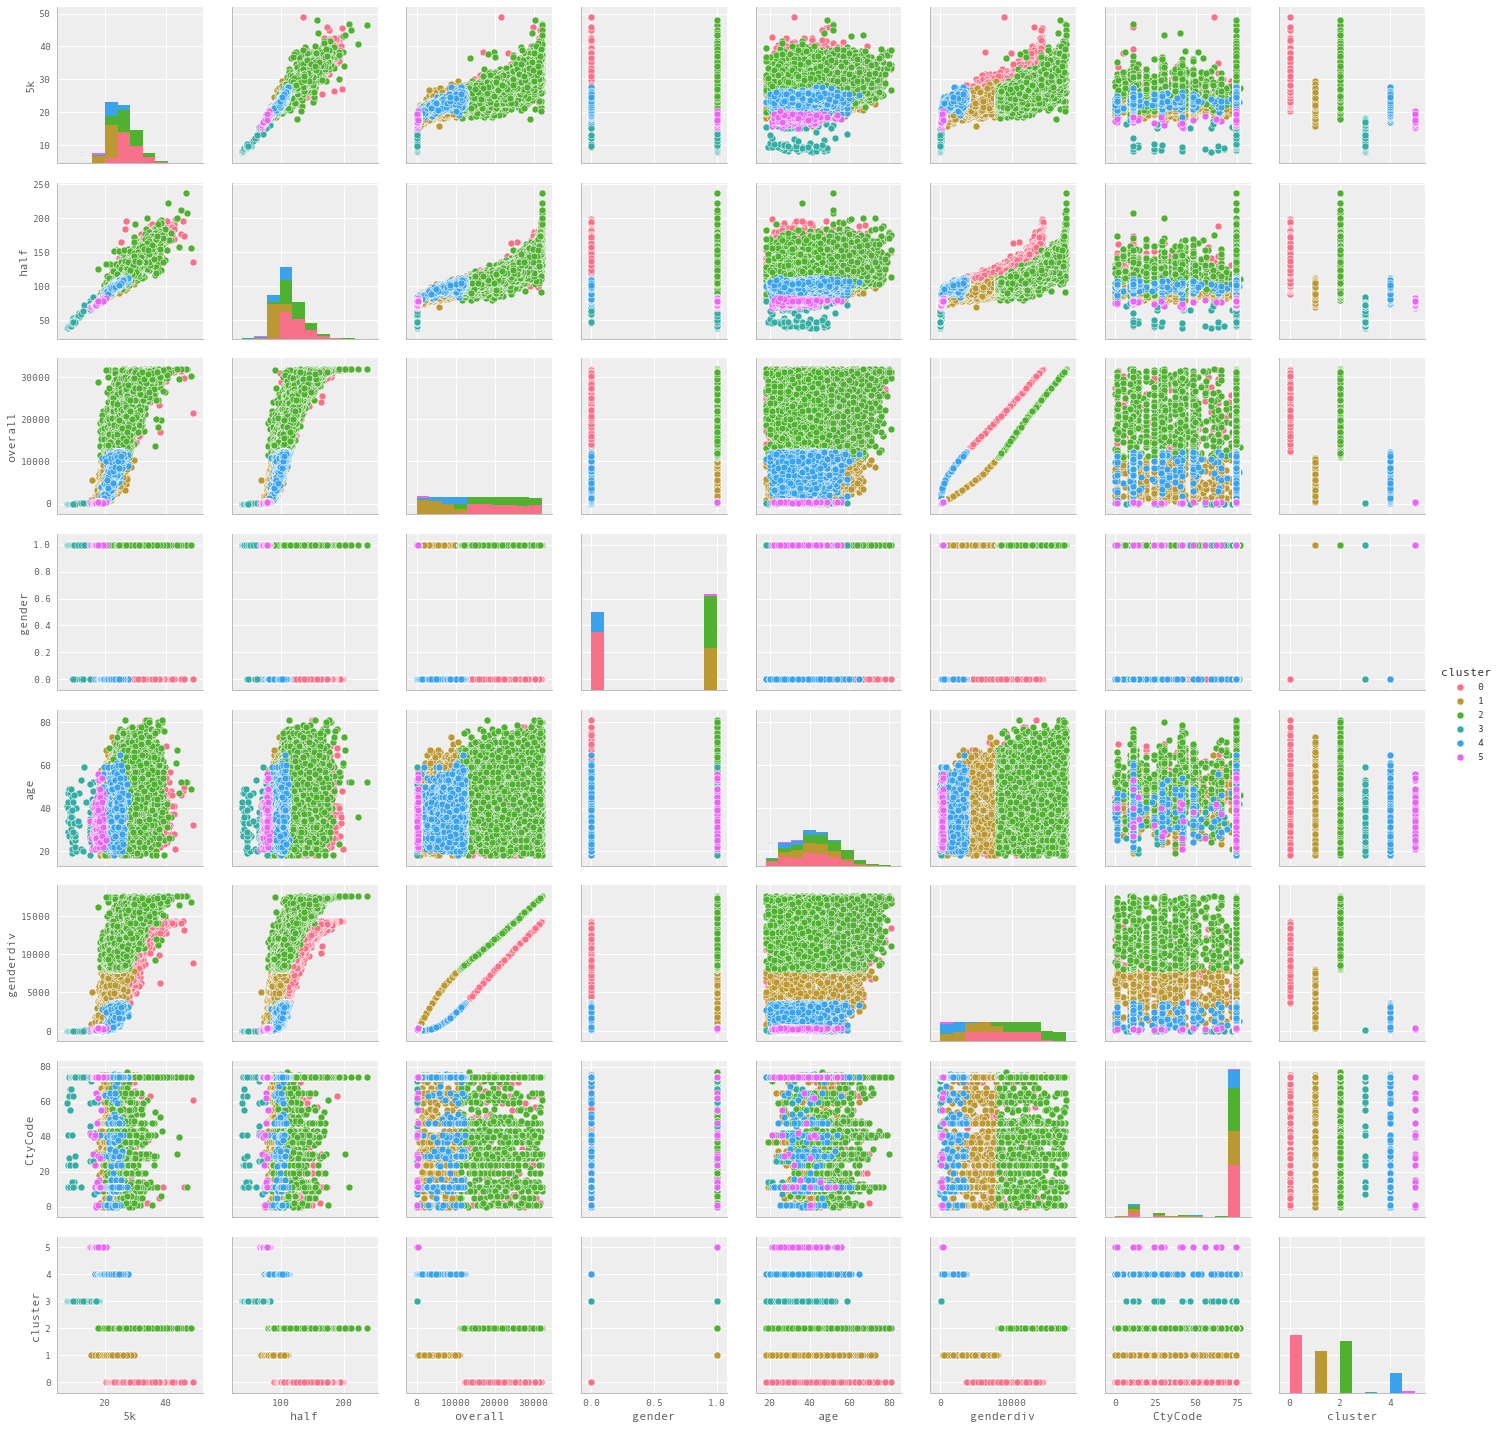

In [286]:
sns.pairplot(labeled_runners, hue='cluster', palette='husl')

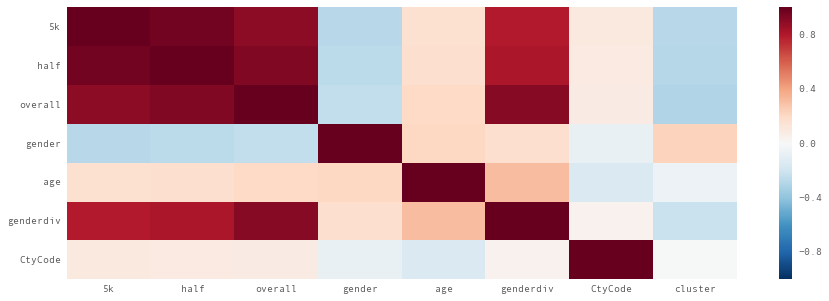

In [300]:
heatmap = labeled_runners.corr()
heatmap = heatmap.copy().drop('cluster')
sns.heatmap(heatmap)

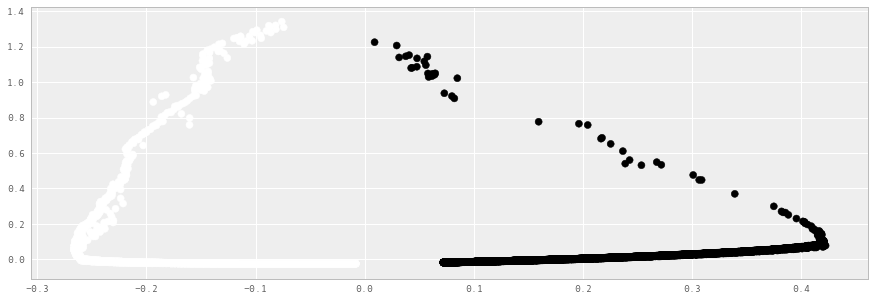

In [559]:
### K-Means

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# # Check the solution against the data.
# print('Comparing k-means clusters against the data:')
# print(pd.crosstab(y, y_pred, rownames=["Actuals"]))

In [560]:
MySpecialPCA.components_

i = np.identity(X.shape[1])

coef = MySpecialPCA.transform(i)

factor_loadings = pd.DataFrame(coef, columns=['PC-1', 'PC-2', 'PC-3', 'PC-4', 'PC-5', 'PC-6', 'PC-7'], index=X.columns)

factor_loadings.sort_values(by='PC-1', ascending=False)

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7
overall,0.473996,0.066112,0.076427,-0.009075,-0.013497,-0.000225,-0.000286
gender,-0.000937,0.518484,0.816519,-0.087201,-0.136757,0.065015,-0.998538
5k,-0.011810,0.639322,0.722294,0.040375,-0.289771,-0.967324,-0.065271
age,-0.024495,0.795700,0.835804,0.245282,0.745021,-0.048767,0.012007
CtyCode,-0.044821,1.049660,0.408496,-0.816695,-0.043918,-0.001761,0.003562
half,-0.050422,1.075308,0.442697,0.488263,-0.528633,0.243391,0.016948
genderdiv,-0.877485,0.201075,0.461591,-0.053707,-0.083777,-0.000341,-0.000169


Number of estimated clusters: 37


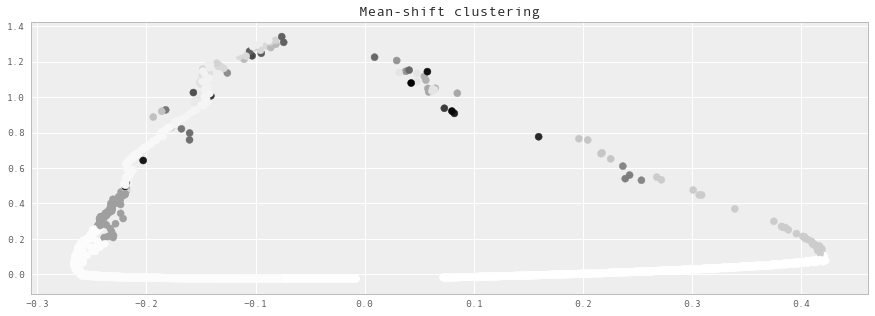

Comparing the assigned categories to the ones in the data:


NameError: name 'y' is not defined

In [308]:
### Meanshift Method

km_start = timer()

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_pca, quantile=0.2, n_samples=200)

# Declare and fit the model.
ms = MeanShift(bandwidth=None, bin_seeding=True)
ms.fit(X_pca)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))
# print(pd.crosstab(y_train, ms))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.title("Mean-shift clustering")
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y,labels))

km_end = timer()
print('')
print(km_end - km_start)

In [ ]:
## Consider adding the cluster number back to the dataset to identify who are the people in that cluster



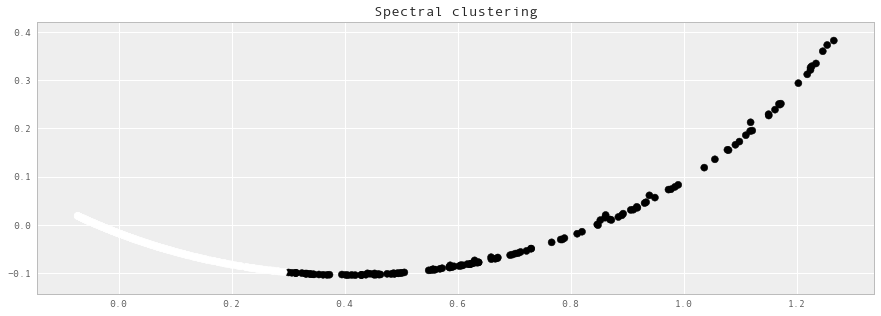

Comparing the assigned categories to the ones in the data:
col_0        0    1
TopGroup           
0         2541    0
1          483  140
3.1610943040004713


In [103]:
### Spectral Clustering

from sklearn.model_selection import train_test_split

#Divide into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.9,
    random_state=42)

X = X_train
y = y_train

sc_start = timer()

# Declare and fit the model.
sc = SpectralClustering(n_clusters=2)

#Predicted clusters.
predict=sc.fit_predict(X_pca)

#Graph results.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predict)
plt.title("Spectral clustering")
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y, predict))

sc_end = timer()
print(sc_end - sc_start)

In [27]:
sc = SpectralClustering(n_clusters=2)

In [ ]:
predict=sc.fit_predict(X_pca)

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predict)
plt.title("Spectral clustering")
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y, predict))

In [ ]:
### Affinity Propogation


# ap_start = timer()

# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation().fit(X_pca)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

# ap_end = timer()
# print(ap_end - ap_start) 

plt.figure(1)
plt.clf()

# Cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
colors = cycle('bgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_pca[cluster_centers_indices[k]]
    plt.plot(X_pca[class_members, 0], X_pca[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_pca[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Affinity Propogation Clustering with {} estimated number of clusters'.format(n_clusters_))
plt.show()


## Bonus attempts... until I ran out of usable columns

In [346]:
## Reloading dataset

#interwebs
runners = pd.read_csv("https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv")

# Assigning column names

runners = runners[[
 '5k',
 '10k',
 '20k',
 'half',
 '25k',
 '30k',
 '35k',
 '40k',
 'official', #time overall
 'name',
 'division',   #mystery variable
 'gender',   #confirmed that contains only M and F entries
 'age',
 'bib',  #ID number
 'genderdiv',  #ranking within gender class
 'ctz', # lots of NaNs - it's citizenship vs country of residence ('country') but many are missing
 'overall', #ranking overall
 'pace', #not really sure, could be approximate pace of each mile? roughly becomes 26.2 when 'official' divided by 'pace'
 'state',  #could group for US participants
 'country',  # could group by country
 'city']]

# Changing datatypes
runners = runners.replace(to_replace='-', value=np.nan)
runners['5k'] = runners['5k'].astype(float)
runners['10k'] = runners['10k'].astype(float)
runners['20k'] = runners['20k'].astype(float)
runners['half'] = runners['half'].astype(float)
runners['25k'] = runners['25k'].astype(float)
runners['30k'] = runners['30k'].astype(float)
runners['35k'] = runners['35k'].astype(float)
runners['40k'] = runners['40k'].astype(float)
runners['official'] = runners['official'].astype(float)
runners['age'] = runners['age'].astype(int)
runners['gender'] = runners['gender'].apply(lambda x: 1 if x == 'M' else 0) # males 1, females 0
runners['country'] = runners['country'].astype('category')
runners['CtyCode'] = runners['country'].cat.codes

runners.shape

(31984, 22)

In [347]:
list(runners)

['5k',
 '10k',
 '20k',
 'half',
 '25k',
 '30k',
 '35k',
 '40k',
 'official',
 'name',
 'division',
 'gender',
 'age',
 'bib',
 'genderdiv',
 'ctz',
 'overall',
 'pace',
 'state',
 'country',
 'city',
 'CtyCode']

In [348]:

### reduce dimensionality even further; maybe take out all time/speed data and see what happens 
### (e.g., Y = overall, x = gender, age, country, etc.)

In [349]:
#ditches NAs and variables with string data
runners = runners.drop(['5k',
 '10k',
 '20k',
 'half',
 '25k',
 '30k',
 '35k',
 '40k',
 'official',
 'name',
 'division', 
 'bib',
 'genderdiv',
 'ctz',
 'pace',
 'state',
 'country',
 'city'], axis=1)

runners = runners.dropna()

runners.shape

(31984, 4)

In [350]:
list(runners)

['gender', 'age', 'overall', 'CtyCode']

In [351]:
#Split into X and y groups
# y = runners['overall']
X = runners.drop('overall', axis=1)

In [352]:
### Normalize the data
X_norm = normalize(X)

In [353]:
### Reduce dimensions

MySpecialPCA = PCA(n_components=None)

# Reduce it to two components.
X_pca = MySpecialPCA.fit_transform(X_norm)

In [354]:
#Run k-means with n clusters
km = KMeans(n_clusters=3, random_state=42)

y_pred = km.fit_predict(X_pca)

running_runners = runners.copy() 
running_runners['cluster'] = km.labels_

running_runners.head()

In [355]:
running_runners = runners.copy() 
running_runners['cluster'] = km.labels_

running_runners.head()

,gender,age,overall,CtyCode,cluster
0,1,47,8,41,0
1,0,33,21,42,0
2,1,41,1,59,0
3,0,24,27,26,0
4,1,40,2,41,0


In [356]:
#estimating number of clusters

bandwidth = estimate_bandwidth(X_pca, quantile=0.2, n_samples=200)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_pca)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print(n_clusters_)

3


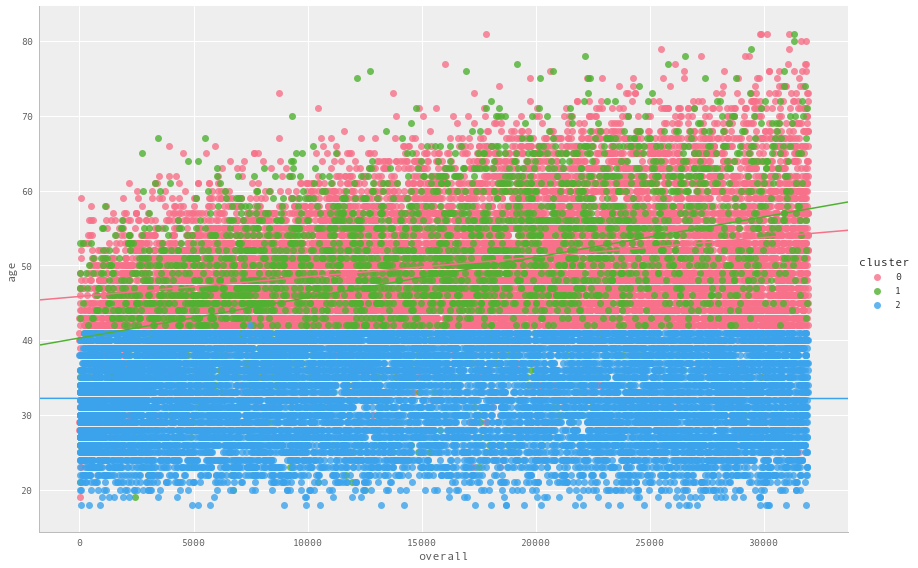

In [357]:
sns.lmplot(x='overall', y='age', hue='cluster', palette='husl', data=running_runners, ci=None, x_ci=None, 
           size=8, aspect=1.5, markers='o')
